# 01. Training
We will use the [Stable Baselines](https://github.com/hill-a/stable-baselines) implementation of the PPO2 algorithm.


To have a clean output, we will filter tensorflow warnings, mostly due to the migration from tf 1.x to 2.x

In [2]:
# Filter tensorflow version warnings
import os

# https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # or any {'0', '1', '2'}
import warnings

# https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)
import tensorflow as tf

tf.get_logger().setLevel("INFO")
tf.autograph.set_verbosity(0)
import logging

tf.get_logger().setLevel(logging.ERROR)

<IPython.core.display.Javascript object>

To create the environment, we use the code from the previous notebook.

In [3]:
import gym
import pandas as pd
import numpy as np

# Our custom environment Named 'IDS_Env' inherits from the 'Env' class from the 'gym' library
class IDS_Env(gym.Env):
    def __init__(self, data):
        super().__init__()
        # The class takes one parameter which is the dataset (precisely the training dataset)
        self.data = data

        # Define action and observation spaces
        self.action_space = gym.spaces.Discrete(2)  # either 0 (NORMAL) or 1 (ATTACK)
        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=(data.shape[1] - 1,), dtype=np.float64
        )

        # Define reward function
        # (true_label, action) -> reward
        self.rewards = {(0, 0): 0, (0, 1): -1, (1, 1): 1, (1, 0): -1}

        # Define the maximim episode length
        self.max_steps = 1000

        # Keep track of steps that go beyond the termination of the episode
        self.steps_beyond_done = None

    def reset(self):
        # This method should be called to start a new episode

        self.steps_beyond_done = None
        self.current_step = 0

        # start from a random point in the data
        self.i = np.random.randint(0, self.data.shape[0])

        # extarct the observation
        self.obs = self.data.iloc[self.i]

        # extract the true label of the observation
        self.label = int(self.obs.pop("label"))

        # return the observation, it should be a numpy array so the '.values' is a must
        return self.obs.values

    def step(self, action):
        # This method is called after each action the agent take

        # Verify that the action took is valid (belongs to the action space, 0 or 1)
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg

        # Calculate if the episode should finish
        info = {}
        done = False
        self.current_step += 1
        if self.current_step >= self.max_steps:
            done = True
            # Update the info dict to signal that the limit was exceeded
            info["reason_to_stop"] = "episode_limit"

        if self.label == 1 and action == 0:
            done = True
            # Update the info dict to signal that the agent missd an attack
            info["reason_to_stop"] = "attack_missed"

        # Calculate the reward based on the true label of the observation and the action tooked
        reward = self.rewards[(self.label, action)]

        # Calculate next state if the episode is not finished yet
        if not done:
            self.i += 1
            if self.i >= self.data.shape[0]:
                self.i = 0

            self.obs = self.data.iloc[self.i]
            self.label = int(self.obs.pop("label"))

        elif self.steps_beyond_done is None:
            self.steps_beyond_done = 0
        else:
            # Warn the user of steps after the episode termination
            if self.steps_beyond_done == 0:
                gym.logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_done += 1
            reward = 0

        # Following the 'gym' interface this method return
        # 1. the new observation (old in case of episode termination),
        # 2. the reward,
        # 3. termination of episode,
        # 4. and, an empty 'dict'.
        return self.obs.values, reward, done, info

<IPython.core.display.Javascript object>

In [4]:
# Load the training data
train_data = pd.read_csv("processed_data/train.csv")

<IPython.core.display.Javascript object>

To spped up the training process, we decided to train the algorithm on multiple environment at the same time. `stable-baselines` provides a utility for that called "*Vectorized Environments*".

In [5]:
from stable_baselines.common.vec_env import DummyVecEnv

n_envs = 16  # the best number that worked for us
env = DummyVecEnv([lambda: IDS_Env(train_data)] * n_envs)

<IPython.core.display.Javascript object>

Now, we import the PPO implementation

In [6]:
from stable_baselines import PPO2

<IPython.core.display.Javascript object>

Then, the first thing to do is define the network architecture:

In [7]:
from stable_baselines.common.policies import FeedForwardPolicy


class CustomPolicy(FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPolicy, self).__init__(
            *args,
            **kwargs,
            net_arch=[128, 64, 32],  # 3 layers shared between value and policy networks
            act_fun=tf.nn.relu,  # Use the ReLU activation function
            feature_extraction="mlp"
        )

<IPython.core.display.Javascript object>

We define the model with the following hyperparametrs:

In [8]:
model = PPO2(
    CustomPolicy,
    env,
    gamma=0.9,
    n_steps=512,
    ent_coef=1e-05,
    learning_rate=lambda progress: progress
    * 0.0021,  # progress decreases from 1 to 0 -> lr decreasesb from 0.0021 to 0
    vf_coef=0.6,
    max_grad_norm=0.8,
    lam=0.8,
    nminibatches=16,
    noptepochs=55,
    cliprange=0.2,
    verbose=0,
    tensorboard_log="log_25",  # define the tensorboard log location
)

<IPython.core.display.Javascript object>

Before launch the model for training, we define a callback to monitor *accuarcy* and *f1-score* for the traning and validation splits.

In [9]:
from stable_baselines.common.callbacks import BaseCallback
from sklearn.metrics import accuracy_score, f1_score
import swifter  # to speed up calculations across pandas dataframe

<IPython.core.display.Javascript object>

In [10]:
class AccF1Callback(BaseCallback):
    def __init__(self, train, val, eval_freq):
        super().__init__()
        self.train_data = train
        self.val_data = val
        self.eval_freq = eval_freq

    def _on_step(self) -> bool:

        # This method will be called by the model after each call to `env.step()`.
        # return: (bool) If the callback returns False, training is aborted early.

        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            super()._on_step()

            # Calculate metrics for training data
            predicted = self.train_data.drop(columns=["label"]).swifter.apply(
                lambda x: self.model.predict(x, deterministic=True)[0], axis=1
            )
            accuracy = accuracy_score(self.train_data["label"], predicted)
            f1 = f1_score(self.train_data["label"], predicted)

            print("-" * 60)
            print(f"timesteps: {self.num_timesteps}")
            print(f"Training   >>> accuracy: {accuracy:.4f}, f1-score: {f1:.4f}")

            # Calculate metrics for validation data
            predicted = self.val_data.drop(columns=["label"]).swifter.apply(
                lambda x: self.model.predict(x, deterministic=True)[0], axis=1
            )
            accuracy = accuracy_score(self.val_data["label"], predicted)
            f1 = f1_score(self.val_data["label"], predicted)
            print(f"Validation >>> accuracy: {accuracy:.4f}, f1-score: {f1:.4f}")
            print("-" * 60)

        return True

<IPython.core.display.Javascript object>

Now, we initialize the validation callback to evaluate the model after each 20,000 steps.

In [11]:
val_data = pd.read_csv("processed_data/val.csv")
eval_callback = AccF1Callback(train_data, val_data, eval_freq=20000 // n_envs)

<IPython.core.display.Javascript object>

Finally we can start the training process where we train the model for 6,000,000 steps

In [12]:
model.learn(6000000, callback=eval_callback)

------------------------------------------------------------
timesteps: 20000
Training   >>> accuracy: 0.9512, f1-score: 0.8792
Validation >>> accuracy: 0.9513, f1-score: 0.8799
------------------------------------------------------------
------------------------------------------------------------
timesteps: 40000
Training   >>> accuracy: 0.9584, f1-score: 0.8958
Validation >>> accuracy: 0.9586, f1-score: 0.8967
------------------------------------------------------------
------------------------------------------------------------
timesteps: 60000
Training   >>> accuracy: 0.9608, f1-score: 0.9024
Validation >>> accuracy: 0.9608, f1-score: 0.9028
------------------------------------------------------------
------------------------------------------------------------
timesteps: 80000
Training   >>> accuracy: 0.9549, f1-score: 0.8906
Validation >>> accuracy: 0.9550, f1-score: 0.8911
------------------------------------------------------------
--------------------------------------------

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

Save the model:

In [ ]:
model.save('ids_drl_model')

# 02. Evaluation

In [13]:
# load the saved model
model = PPO2.load("ids_drl_model")

<IPython.core.display.Javascript object>

As in notebook 02, we can test the model for 10 episodes and see that the model perform better.

In [14]:
env = env.envs[0]
all_rewards = []
all_lengths = []
for i in range(10):
    print("-" * 50)
    print(f"Episode {i+1:02}")
    print("-" * 50)

    ep_reward = 0
    obs = env.reset()
    done = False
    while not done:
        t_label = env.label
        action = model.predict(obs, deterministic=True)[0]
        obs, rew, done, info = env.step(action)

        print(
            f"true_label: {t_label}, action: {action}, reward: {rew:>2}, done: {done}, {info}"
        )
        ep_reward += rew
    print(f"\n>>Episode reward: {ep_reward}")
    print("-" * 50)
    all_rewards.append(ep_reward)
    all_lengths.append(env.current_step)

print("\nRewards", all_rewards)
print(f"Mean Episodes Reward: {np.mean(all_rewards)}")
print("\nLengths", all_lengths)
print(f"Mean Episodes Length: {np.mean(all_lengths)}")

--------------------------------------------------
Episode 01
--------------------------------------------------
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 

true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, re

true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, re

true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, re

true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, re

true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, re

true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, re

true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, re

true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, re

true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, re

true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 1, action: 1, reward:  1, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, reward:  0, done: False, {}
true_label: 0, action: 0, re

<IPython.core.display.Javascript object>

Because we have used a dataset,we can compute the different metrics and compare it with other researchers' work.

In [15]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    balanced_accuracy_score,
    confusion_matrix,
)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>

### 01. Results on training data

accuarcy: 0.9915451089599081
recall: 0.979640799310029
precision: 0.9774221125951257
f1-score: 0.9785301983101407
balanced accuarcy: 0.9870502317666768

Confusion matrix:


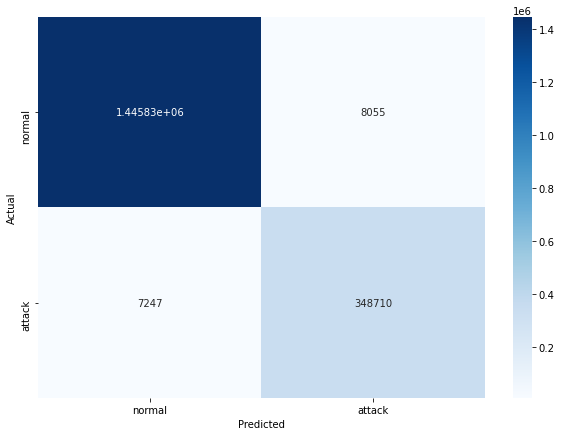

<IPython.core.display.Javascript object>

In [16]:
pred = train_data.drop(columns=["label"]).swifter.apply(
    lambda x: model.predict(x, deterministic=True)[0], axis=1
)

print("accuarcy:", accuracy_score(train_data["label"], pred))
print("recall:", recall_score(train_data["label"], pred))
print("precision:", precision_score(train_data["label"], pred))
print("f1-score:", f1_score(train_data["label"], pred))
print("balanced accuarcy:", balanced_accuracy_score(train_data["label"], pred))

print("\nConfusion matrix:")
cm = confusion_matrix(train_data["label"], pred)
df_cm = pd.DataFrame(cm, columns=["normal", "attack"], index=["normal", "attack"])
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="g")

### 02. Results on validitaion data

accuarcy: 0.9915771559916898
recall: 0.9800493162967945
precision: 0.9772999072325111
f1-score: 0.9786726807729546
balanced accuarcy: 0.9872289858656089

Confusion matrix:


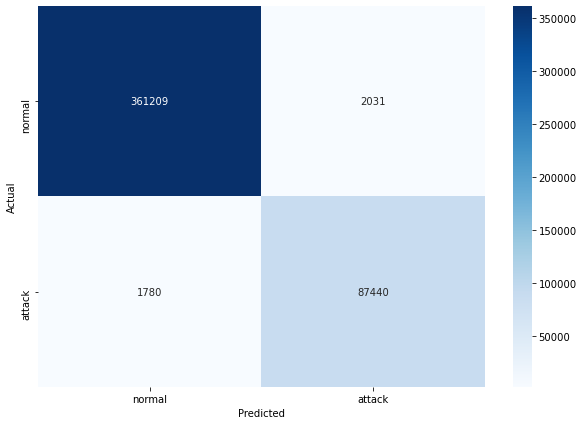

<IPython.core.display.Javascript object>

In [17]:
pred = val_data.drop(columns=["label"]).swifter.apply(
    lambda x: model.predict(x, deterministic=True)[0], axis=1
)

print("accuarcy:", accuracy_score(val_data["label"], pred))
print("recall:", recall_score(val_data["label"], pred))
print("precision:", precision_score(val_data["label"], pred))
print("f1-score:", f1_score(val_data["label"], pred))
print("balanced accuarcy:", balanced_accuracy_score(val_data["label"], pred))

print("\nConfusion matrix:")
cm = confusion_matrix(val_data["label"], pred)
df_cm = pd.DataFrame(cm, columns=["normal", "attack"], index=["normal", "attack"])
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="g")

### 03. Results on test data

In [18]:
test_data = pd.read_csv("processed_data/test.csv")

<IPython.core.display.Javascript object>

accuarcy: 0.9914122947225483
recall: 0.9792600041300424
precision: 0.977180690940367
f1-score: 0.9782192425839145
balanced accuarcy: 0.9868261526340474

Confusion matrix:


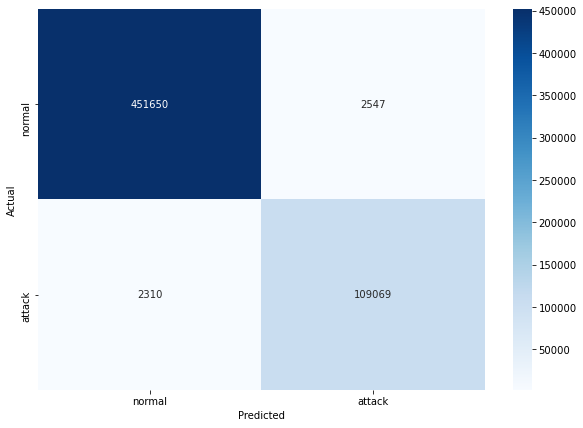

<IPython.core.display.Javascript object>

In [19]:
pred = test_data.drop(columns=["label"]).swifter.apply(
    lambda x: model.predict(x, deterministic=True)[0], axis=1
)

print("accuarcy:", accuracy_score(test_data["label"], pred))
print("recall:", recall_score(test_data["label"], pred))
print("precision:", precision_score(test_data["label"], pred))
print("f1-score:", f1_score(test_data["label"], pred))
print("balanced accuarcy:", balanced_accuracy_score(test_data["label"], pred))

print("\nConfusion matrix:")
cm = confusion_matrix(test_data["label"], pred)
df_cm = pd.DataFrame(cm, columns=["normal", "attack"], index=["normal", "attack"])
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="g")

### 04. ROC and PR on test data:

In [20]:
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)

<IPython.core.display.Javascript object>

In [21]:
# Calculate the scores
scores = test_data.drop(columns=["label"]).swifter.apply(
    lambda x: model.action_probability(x)[1], axis=1
)

<IPython.core.display.Javascript object>

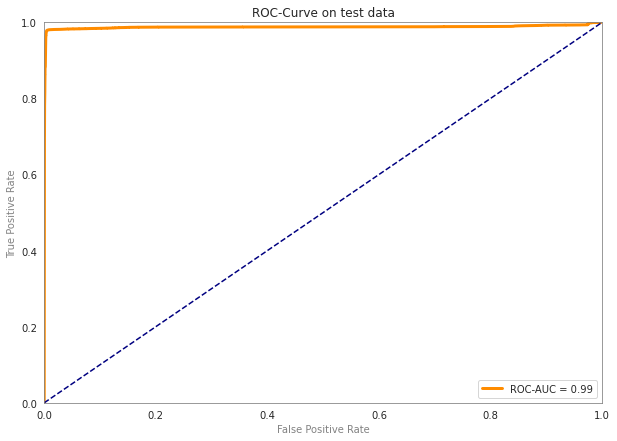

<IPython.core.display.Javascript object>

In [22]:
fpr, tpr, _ = roc_curve(test_data["label"], scores)
roc_auc = auc(fpr, tpr)

sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.plot(fpr, tpr, color="darkorange", lw=3, label="ROC-AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Curve on test data")
plt.legend(loc="lower right")

ax.spines["bottom"].set_color("#828282")
ax.spines["left"].set_color("#828282")
ax.spines["right"].set_color("#828282")
ax.spines["top"].set_color("#828282")

ax.yaxis.label.set_color("#828282")
ax.xaxis.label.set_color("#828282")
plt.show()

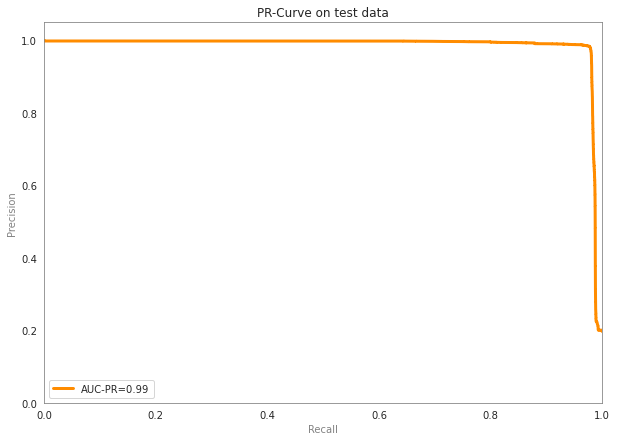

<IPython.core.display.Javascript object>

In [23]:
precisions, recalls, thresholds = precision_recall_curve(test_data["label"], scores)
average_prec = average_precision_score(test_data["label"], scores)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.step(
    recalls,
    precisions,
    where="post",
    lw=3,
    color="darkorange",
    label="AUC-PR={0:0.2f}".format(average_prec),
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-Curve on test data")

plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend()

ax.spines["bottom"].set_color("#828282")
ax.spines["left"].set_color("#828282")
ax.spines["right"].set_color("#828282")
ax.spines["top"].set_color("#828282")
ax.yaxis.label.set_color("#828282")
ax.xaxis.label.set_color("#828282")

plt.show()